# Prediction des distances

## Importation des packages necessaires

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import time
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

## Creation du Frame

In [2]:
import glob
import os

all_files = glob.glob("aubagne_propre.csv")
df = pd.concat((pd.read_csv(f) for f in all_files))

## Affichage de l'entete du frame

In [3]:
df

,date,DistX,DistY,T_Amb_h,T_Fc_h,Vbat
0,2018-10-10 22:28:00+00:00,1481.0,4068.0,18.435,16.870,12967.5
1,2018-10-10 22:40:00+00:00,1481.0,4068.0,18.370,16.870,12961.0
2,2018-10-10 22:52:00+00:00,1481.0,4068.0,18.430,16.870,12957.0
3,2018-10-10 23:04:00+00:00,1481.0,4068.0,18.370,16.870,12954.0
4,2018-10-10 23:16:00+00:00,1481.0,4068.0,18.370,16.810,12952.0
...,...,...,...,...,...,...
166046,2023-02-10 18:52:00+00:00,1514.0,3795.0,2.560,4.930,12867.0
166047,2023-02-10 19:04:00+00:00,1514.0,3794.0,2.030,4.375,12856.0
166048,2023-02-10 19:16:00+00:00,1514.0,3792.0,1.500,3.810,12845.0
166049,2023-02-10 19:28:00+00:00,1515.0,3791.0,1.120,3.370,12837.0


## Renommer les colonnes

In [4]:
df = df.rename({"DistX":"distx", "DistY":"disty",},axis=1)

## Definir la colonne index

In [5]:
df = df.set_index("date")
df.head()

,distx,disty,T_Amb_h,T_Fc_h,Vbat
date,,,,,
2018-10-10 22:28:00+00:00,1481.0,4068.0,18.435,16.87,12967.5
2018-10-10 22:40:00+00:00,1481.0,4068.0,18.370,16.87,12961.0
2018-10-10 22:52:00+00:00,1481.0,4068.0,18.430,16.87,12957.0
2018-10-10 23:04:00+00:00,1481.0,4068.0,18.370,16.87,12954.0
2018-10-10 23:16:00+00:00,1481.0,4068.0,18.370,16.81,12952.0


## Mettre la date (l'index) sous un format exploitable

In [6]:
df.index = pd.to_datetime(df.index, format="mixed")
df.head()

,distx,disty,T_Amb_h,T_Fc_h,Vbat
date,,,,,
2018-10-10 22:28:00+00:00,1481.0,4068.0,18.435,16.87,12967.5
2018-10-10 22:40:00+00:00,1481.0,4068.0,18.370,16.87,12961.0
2018-10-10 22:52:00+00:00,1481.0,4068.0,18.430,16.87,12957.0
2018-10-10 23:04:00+00:00,1481.0,4068.0,18.370,16.87,12954.0
2018-10-10 23:16:00+00:00,1481.0,4068.0,18.370,16.81,12952.0


## Classer le frame par date croissante

In [7]:
df.sort_values(by=['date'], inplace=True)
df.head()

,distx,disty,T_Amb_h,T_Fc_h,Vbat
date,,,,,
2018-10-10 22:28:00+00:00,1481.0,4068.0,18.435,16.87,12967.5
2018-10-10 22:40:00+00:00,1481.0,4068.0,18.370,16.87,12961.0
2018-10-10 22:52:00+00:00,1481.0,4068.0,18.430,16.87,12957.0
2018-10-10 23:04:00+00:00,1481.0,4068.0,18.370,16.87,12954.0
2018-10-10 23:16:00+00:00,1481.0,4068.0,18.370,16.81,12952.0


## Afficher le frame

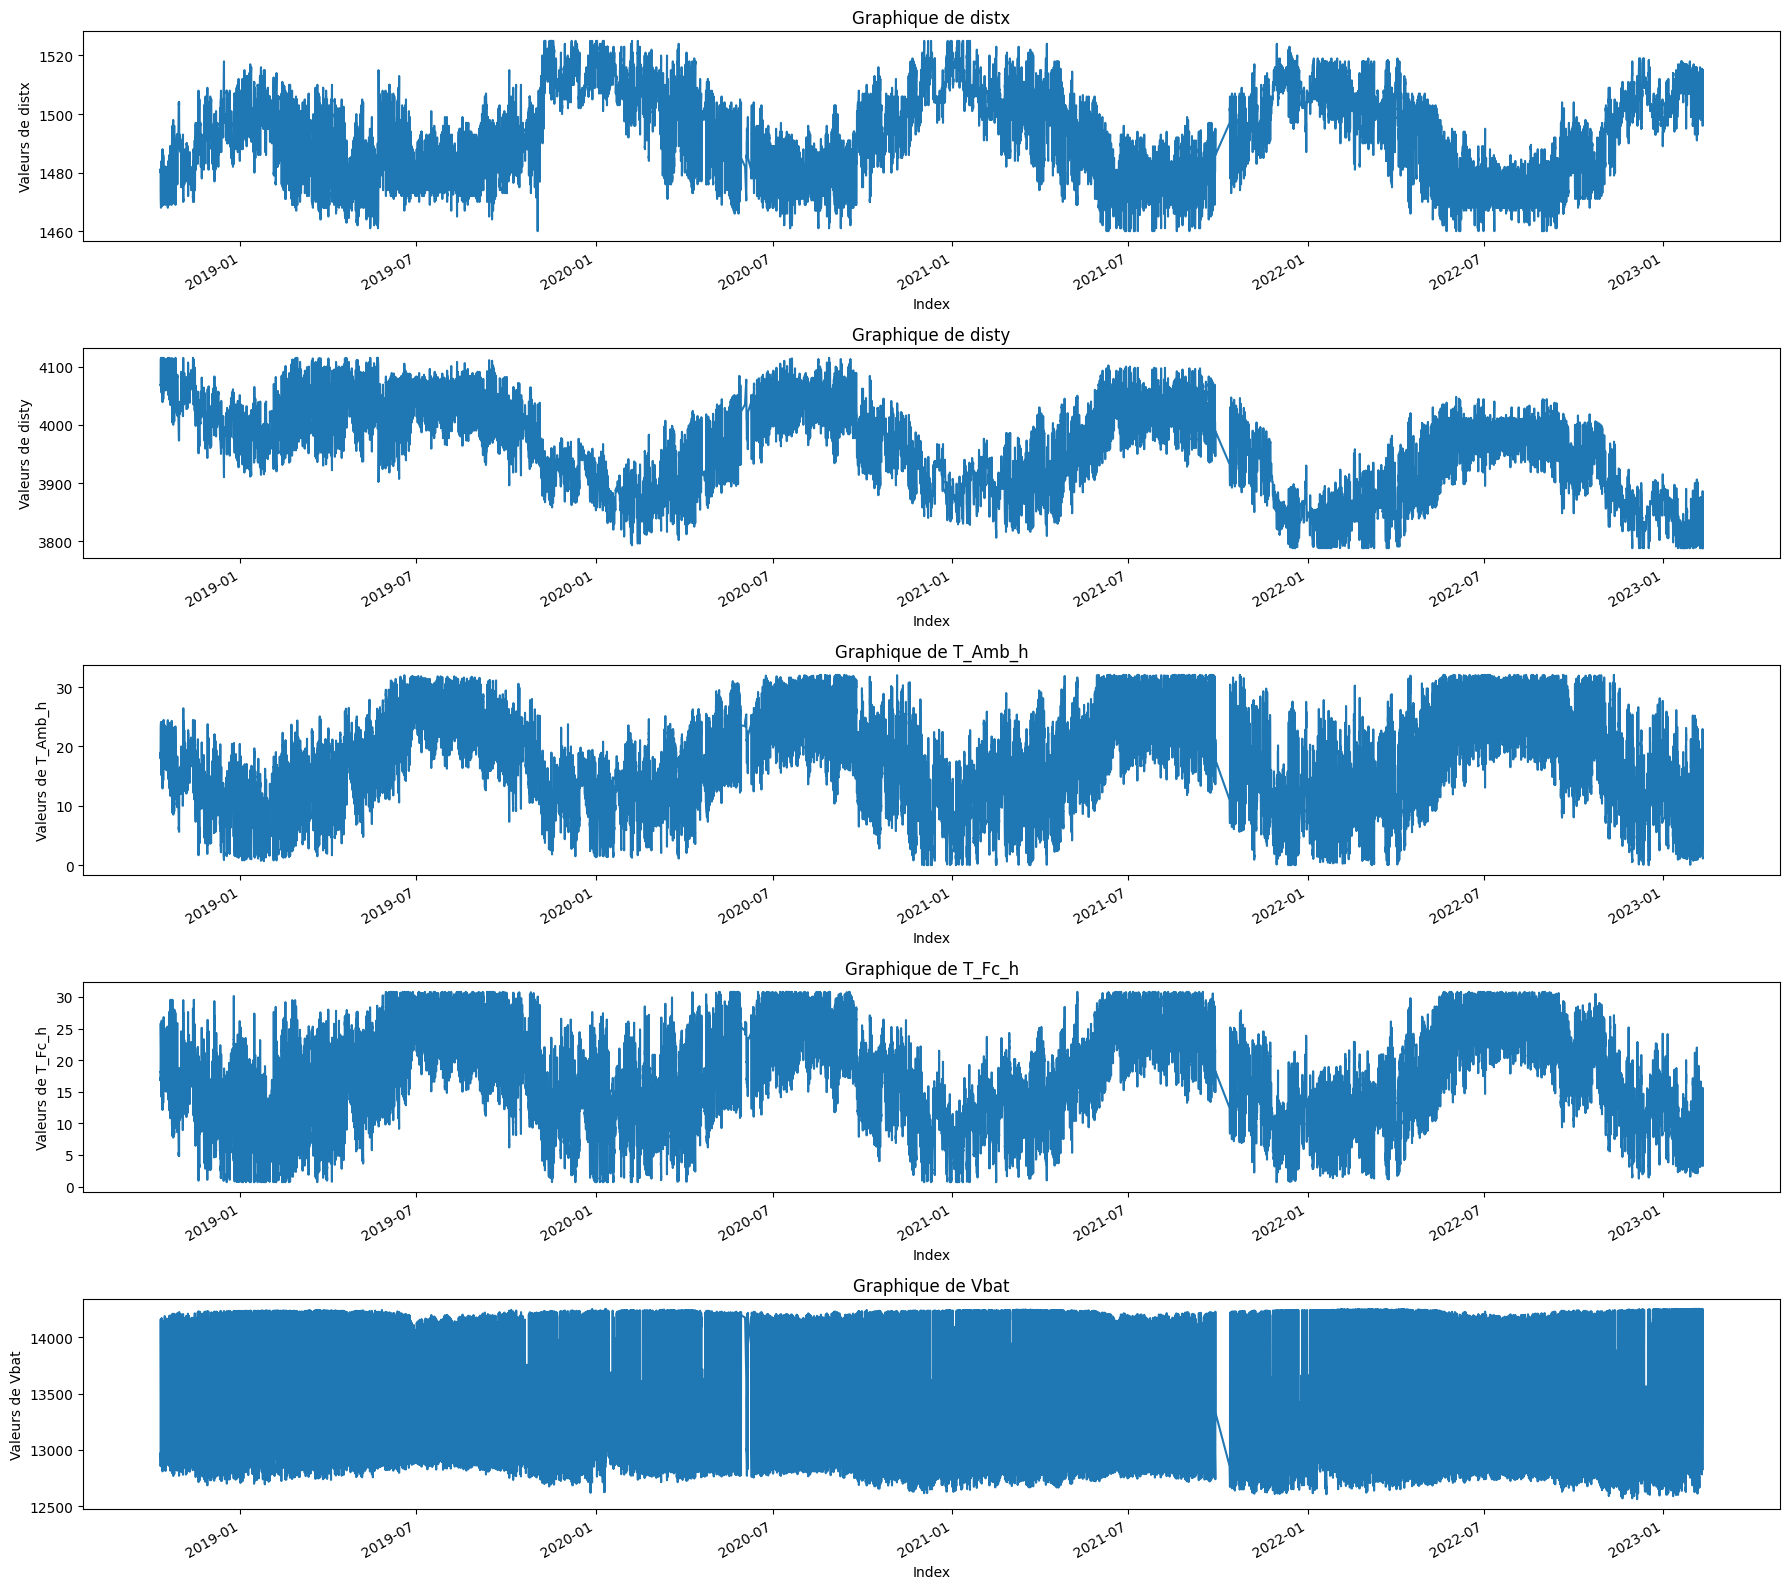

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18, 16))

df['distx'].plot(ax=axes[0])
axes[0].set_title('Graphique de distx')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Valeurs de distx')

df['disty'].plot(ax=axes[1])
axes[1].set_title('Graphique de disty')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Valeurs de disty')

df['T_Amb_h'].plot(ax=axes[2])
axes[2].set_title('Graphique de T_Amb_h')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Valeurs de T_Amb_h')

df['T_Fc_h'].plot(ax=axes[3])
axes[3].set_title('Graphique de T_Fc_h')
axes[3].set_xlabel('Index')
axes[3].set_ylabel('Valeurs de T_Fc_h')

df['Vbat'].plot(ax=axes[4])
axes[4].set_title('Graphique de Vbat')
axes[4].set_xlabel('Index')
axes[4].set_ylabel('Valeurs de Vbat')

plt.tight_layout()
plt.show()

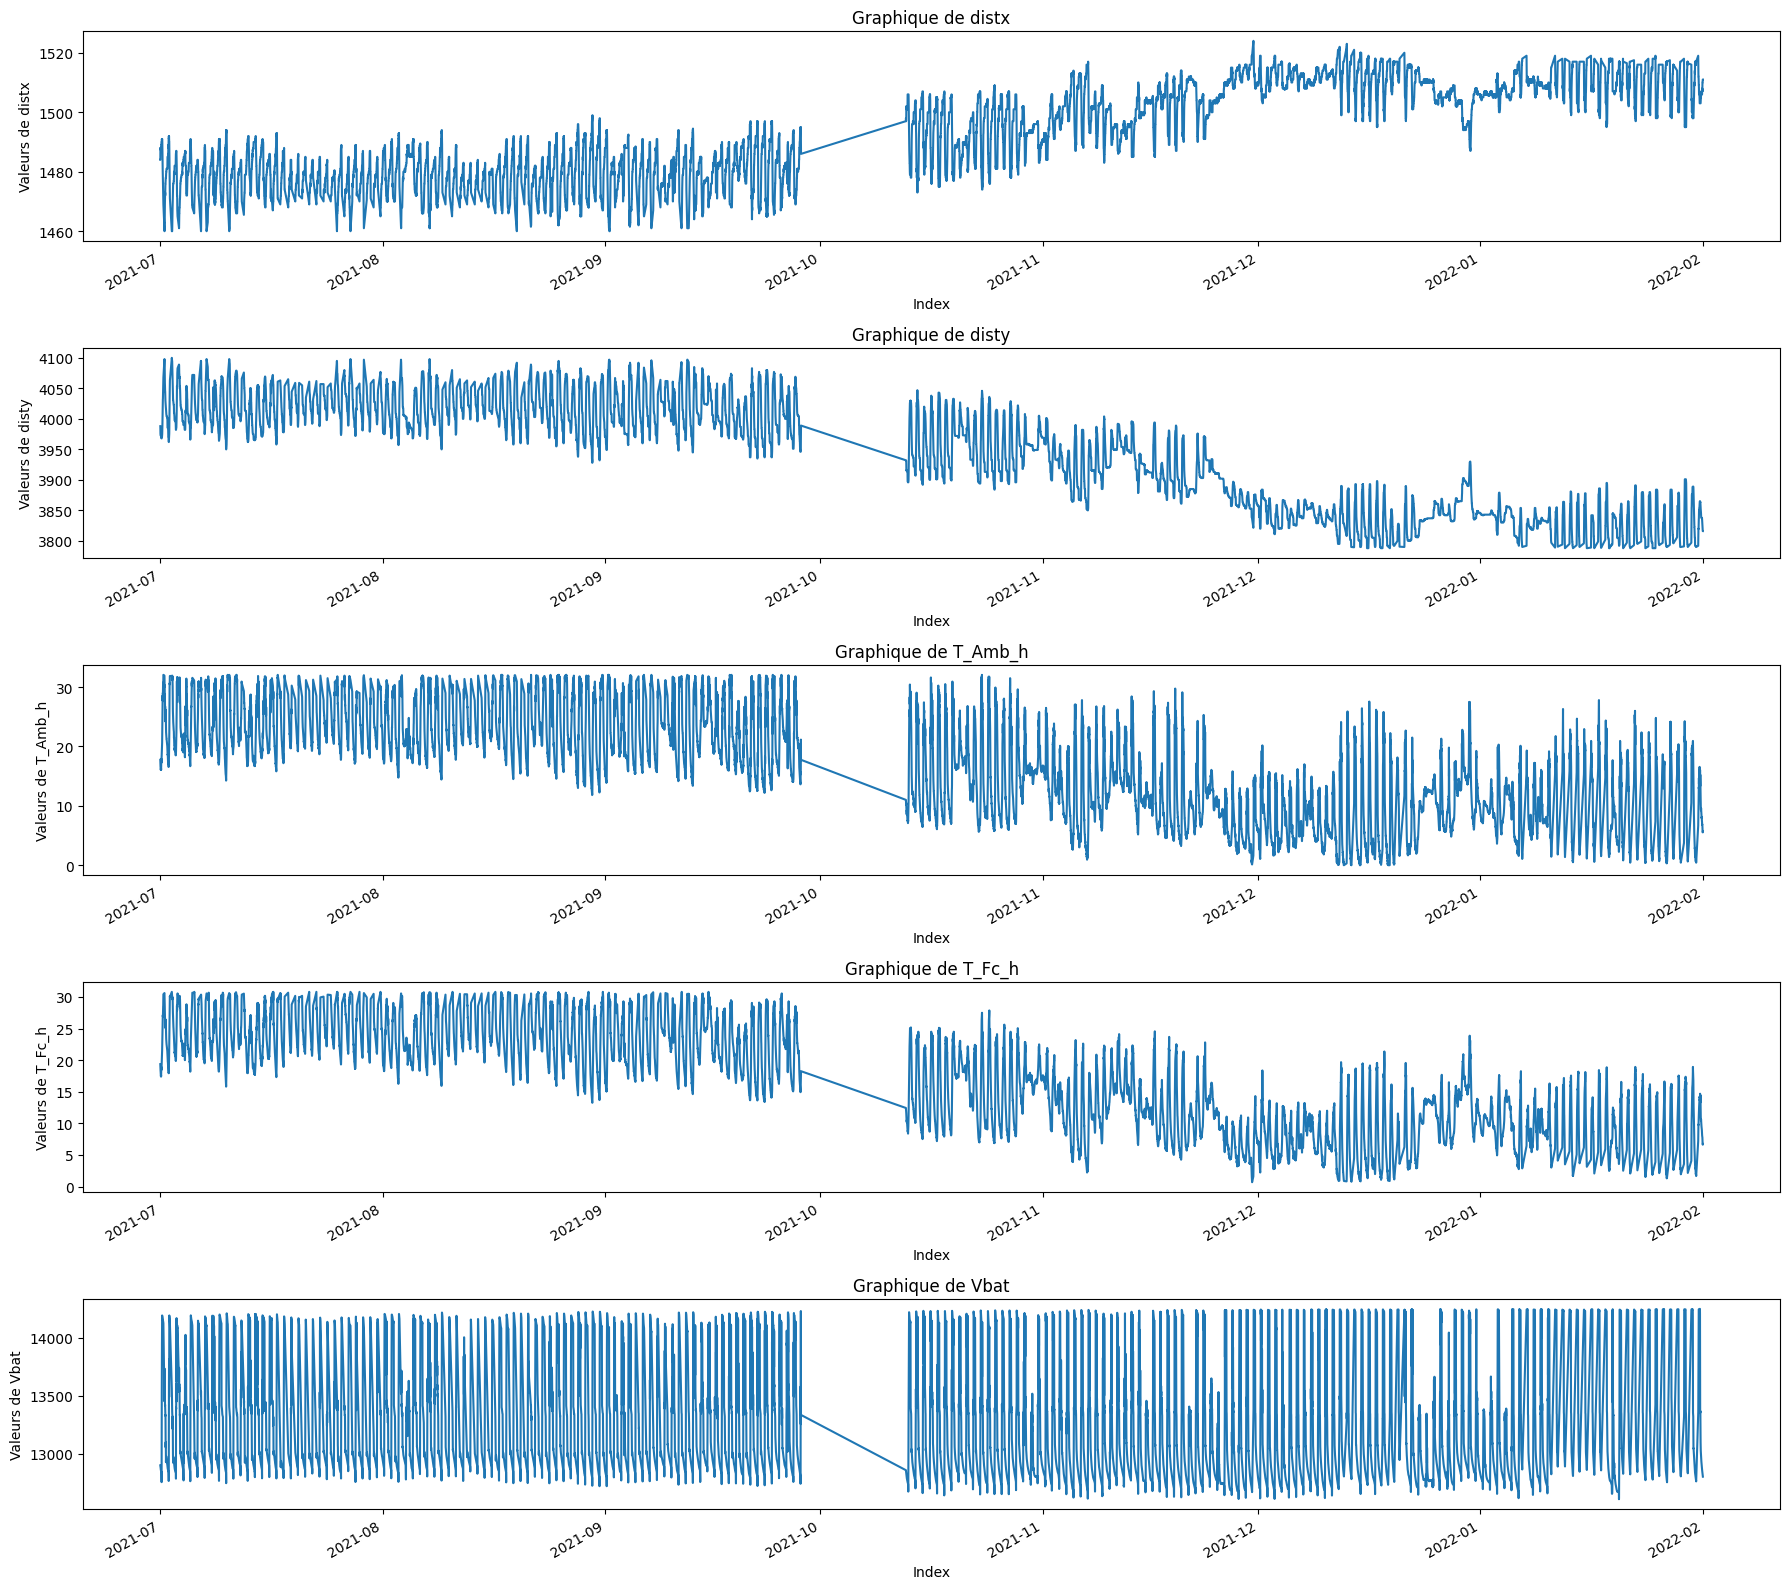

In [9]:
start_date = '2021-07-01'
end_date = '2022-01-31'

df_filtered = df.loc[start_date:end_date]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18, 16))

df_filtered['distx'].plot(ax=axes[0])
axes[0].set_title('Graphique de distx')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Valeurs de distx')

df_filtered['disty'].plot(ax=axes[1])
axes[1].set_title('Graphique de disty')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Valeurs de disty')

df_filtered['T_Amb_h'].plot(ax=axes[2])
axes[2].set_title('Graphique de T_Amb_h')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Valeurs de T_Amb_h')

df_filtered['T_Fc_h'].plot(ax=axes[3])
axes[3].set_title('Graphique de T_Fc_h')
axes[3].set_xlabel('Index')
axes[3].set_ylabel('Valeurs de T_Fc_h')

df_filtered['Vbat'].plot(ax=axes[4])
axes[4].set_title('Graphique de Vbat')
axes[4].set_xlabel('Index')
axes[4].set_ylabel('Valeurs de Vbat')

plt.tight_layout()
plt.show()

## Afficher les donnees sous certaines conditions

In [10]:
df[(df.index > "2020-01-01") & (df.index < "2021-01-01")]

,distx,disty,T_Amb_h,T_Fc_h,Vbat
date,,,,,
2020-01-01 00:04:00+00:00,1521.0,3867.0,2.50,1.560,12934.0
2020-01-01 00:16:00+00:00,1521.0,3867.0,2.31,1.405,12931.0
2020-01-01 00:28:00+00:00,1521.0,3867.0,2.37,1.430,12929.0
2020-01-01 00:40:00+00:00,1521.0,3867.0,2.31,1.370,12928.0
2020-01-01 00:52:00+00:00,1522.0,3866.0,2.18,1.120,12926.0
...,...,...,...,...,...
2020-12-31 23:04:00+00:00,1519.0,3865.0,5.06,5.750,12833.0
2020-12-31 23:16:00+00:00,1519.0,3865.0,5.06,5.810,12830.0
2020-12-31 23:28:00+00:00,1520.0,3865.0,5.18,5.930,12828.0


## Creation des Features

In [11]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import date
import holidays

In [12]:
def set_features(df):
    # Copie du dataframe original pour éviter de le modifier directement
    df = df.copy()
    
    # Ajout des caractéristiques temporelles
    df["minuteofhour"] = df.index.minute  # Minute de l'heure
    df['minuteofday'] = df.index.hour * 60 + df.index.minute  # Minute du jour
    df['minuteofmonth'] = df.index.day * 24 * 60 + df['minuteofday']  # Minute du mois
    df['minuteofyear'] = df.index.dayofyear * 24 * 60 + df['minuteofday']  # Minute de l'année
    df["hourofday"] = df.index.hour  # Heure de la journée
    df['hourofmonth'] = df.index.day * 24 + df['hourofday']  # Heure du mois
    df['hourofyear'] = df.index.dayofyear * 24 + df['hourofday']  # Heure de l'année
    df['dayofweek'] = df.index.dayofweek  # Jour de la semaine (lundi=0, dimanche=6)
    df["dayofmonth"] = df.index.day  # Jour du mois
    df["dayofyear"] = df.index.dayofyear  # Jour de l'année
    df['weekofmonth'] = (df['dayofmonth'] - 1) // 7 + 1  # Semaine du mois
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month  # Mois de l'année
    df['quarter'] = df.index.quarter  # Trimestre de l'année
    df["year"] = df.index.year  # Année
    return df

In [13]:
df = set_features(df)
df

,distx,disty,T_Amb_h,T_Fc_h,Vbat,minuteofhour,minuteofday,minuteofmonth,minuteofyear,hourofday,hourofmonth,hourofyear,dayofweek,dayofmonth,dayofyear,weekofmonth,weekofyear,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,
2018-10-10 22:28:00+00:00,1481.0,4068.0,18.435,16.870,12967.5,28,1348,15748,408868,22,262,6814,2,10,283,2,41,10,4,2018
2018-10-10 22:40:00+00:00,1481.0,4068.0,18.370,16.870,12961.0,40,1360,15760,408880,22,262,6814,2,10,283,2,41,10,4,2018
2018-10-10 22:52:00+00:00,1481.0,4068.0,18.430,16.870,12957.0,52,1372,15772,408892,22,262,6814,2,10,283,2,41,10,4,2018
2018-10-10 23:04:00+00:00,1481.0,4068.0,18.370,16.870,12954.0,4,1384,15784,408904,23,263,6815,2,10,283,2,41,10,4,2018
2018-10-10 23:16:00+00:00,1481.0,4068.0,18.370,16.810,12952.0,16,1396,15796,408916,23,263,6815,2,10,283,2,41,10,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 18:52:00+00:00,1514.0,3795.0,2.560,4.930,12867.0,52,1132,15532,60172,18,258,1002,4,10,41,2,6,2,1,2023
2023-02-10 19:04:00+00:00,1514.0,3794.0,2.030,4.375,12856.0,4,1144,15544,60184,19,259,1003,4,10,41,2,6,2,1,2023
2023-02-10 19:16:00+00:00,1514.0,3792.0,1.500,3.810,12845.0,16,1156,15556,60196,19,259,1003,4,10,41,2,6,2,1,2023


In [14]:
def set_holidays(df, country, state, start_year, end_year):
    # Copie du dataframe original pour éviter de le modifier directement
    df = df.copy()
    
    # Création d'un dictionnaire contenant les dates des jours fériés
    list_holidays = holidays.CountryHoliday(country, state=state, years=range(start_year, end_year+1))
    
    # Ajout d'une colonne pour les jours fériés
    df['holidays'] = df.index.to_series().apply(lambda x: 1 if x in list_holidays else 0)
    
    return df

In [15]:
df = set_holidays(df, "FRA", "Métropole", 2018, 2023)
df

,distx,disty,T_Amb_h,T_Fc_h,Vbat,minuteofhour,minuteofday,minuteofmonth,minuteofyear,hourofday,...,hourofyear,dayofweek,dayofmonth,dayofyear,weekofmonth,weekofyear,month,quarter,year,holidays
date,,,,,,,,,,,,,,,,,,,,,
2018-10-10 22:28:00+00:00,1481.0,4068.0,18.435,16.870,12967.5,28,1348,15748,408868,22,...,6814,2,10,283,2,41,10,4,2018,0
2018-10-10 22:40:00+00:00,1481.0,4068.0,18.370,16.870,12961.0,40,1360,15760,408880,22,...,6814,2,10,283,2,41,10,4,2018,0
2018-10-10 22:52:00+00:00,1481.0,4068.0,18.430,16.870,12957.0,52,1372,15772,408892,22,...,6814,2,10,283,2,41,10,4,2018,0
2018-10-10 23:04:00+00:00,1481.0,4068.0,18.370,16.870,12954.0,4,1384,15784,408904,23,...,6815,2,10,283,2,41,10,4,2018,0
2018-10-10 23:16:00+00:00,1481.0,4068.0,18.370,16.810,12952.0,16,1396,15796,408916,23,...,6815,2,10,283,2,41,10,4,2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 18:52:00+00:00,1514.0,3795.0,2.560,4.930,12867.0,52,1132,15532,60172,18,...,1002,4,10,41,2,6,2,1,2023,0
2023-02-10 19:04:00+00:00,1514.0,3794.0,2.030,4.375,12856.0,4,1144,15544,60184,19,...,1003,4,10,41,2,6,2,1,2023,0
2023-02-10 19:16:00+00:00,1514.0,3792.0,1.500,3.810,12845.0,16,1156,15556,60196,19,...,1003,4,10,41,2,6,2,1,2023,0


## Numeriser au besoin toutes les colonnes qui ne sont pas numeriques

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166051 entries, 2018-10-10 22:28:00+00:00 to 2023-02-10 19:40:00+00:00
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   distx          166051 non-null  float64
 1   disty          166051 non-null  float64
 2   T_Amb_h        166051 non-null  float64
 3   T_Fc_h         166051 non-null  float64
 4   Vbat           166051 non-null  float64
 5   minuteofhour   166051 non-null  int32  
 6   minuteofday    166051 non-null  int32  
 7   minuteofmonth  166051 non-null  int32  
 8   minuteofyear   166051 non-null  int32  
 9   hourofday      166051 non-null  int32  
 10  hourofmonth    166051 non-null  int32  
 11  hourofyear     166051 non-null  int32  
 12  dayofweek      166051 non-null  int32  
 13  dayofmonth     166051 non-null  int32  
 14  dayofyear      166051 non-null  int32  
 15  weekofmonth    166051 non-null  int32  
 16  weekofyear     166051 non-nu

## Test de stationnarité

la p valeur est la probabilite que l'ghypothese nulle soit vraie. la p valeur doit etre inferieure au pourcentage et la statisque inferieure a la valeur critique

In [17]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
        
#test de stationnarite
print("Serie distx:")
check_stationarity(df['distx'])
print("\nSerie disty:")
check_stationarity(df['disty'])

Serie distx:
ADF Statistic: -12.357147388185606
p-value: 5.652777414736498e-23
Critical Values:
   1%, -3.430389400391267
Critical Values:
   5%, -2.861557414431936
Critical Values:
   10%, -2.5667792690794555

Serie disty:
ADF Statistic: -9.980877414822045
p-value: 2.116414516407072e-17
Critical Values:
   1%, -3.430389400391267
Critical Values:
   5%, -2.861557414431936
Critical Values:
   10%, -2.5667792690794555


La fonction check_stationarity que vous avez écrite utilise le test de Dickey-Fuller augmenté (ADF) pour vérifier la stationnarité d'une série temporelle. Voici comment interpréter les résultats du test de stationnarité :

Interprétation des Résultats du Test ADF
ADF Statistic : C'est la statistique de test calculée. Elle est comparée aux valeurs critiques pour déterminer si la série est stationnaire.
p-value : La valeur p associée au test. Elle indique la probabilité de rejeter l'hypothèse nulle (que la série n'est pas stationnaire) à un certain niveau de confiance.
Critical Values : Les valeurs critiques pour différents niveaux de signification (1%, 5%, 10%). Elles sont utilisées pour comparer la statistique de test et décider si l'hypothèse nulle peut être rejetée.
Pas-à-Pas pour Interpréter les Résultats
Étape 1 : Hypothèses
Hypothèse nulle (H0) : La série temporelle n'est pas stationnaire.
Hypothèse alternative (H1) : La série temporelle est stationnaire.
Étape 2 : Comparer l'ADF Statistic aux Critical Values
Si l'ADF Statistic est plus petite que les valeurs critiques (c'est-à-dire, plus négative), vous pouvez rejeter l'hypothèse nulle en faveur de l'hypothèse alternative, indiquant que la série est stationnaire.
Étape 3 : Examiner la p-value
Si la p-value est inférieure à un certain seuil de signification (par exemple 0.05), vous pouvez rejeter l'hypothèse nulle. Une p-value basse (inférieure à 0.05) indique que la série est probablement stationnaire.
Exemple d'Interprétation
Supposons les résultats suivants pour df['distx'] :
ADF Statistic: -3.500
p-value: 0.015
Critical Values:
1%: -3.430
5%: -2.860
10%: -2.570
Interprétation pour distx :
L'ADF Statistic (-3.500) est plus petite que les valeurs critiques à 1% (-3.430), 5% (-2.860) et 10% (-2.570).
La p-value (0.015) est inférieure à 0.05.
Conclusion : Vous pouvez rejeter l'hypothèse nulle à tous les niveaux de signification (1%, 5%, 10%). Cela signifie que la série distx est stationnaire.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166051 entries, 2018-10-10 22:28:00+00:00 to 2023-02-10 19:40:00+00:00
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   distx          166051 non-null  float64
 1   disty          166051 non-null  float64
 2   T_Amb_h        166051 non-null  float64
 3   T_Fc_h         166051 non-null  float64
 4   Vbat           166051 non-null  float64
 5   minuteofhour   166051 non-null  int32  
 6   minuteofday    166051 non-null  int32  
 7   minuteofmonth  166051 non-null  int32  
 8   minuteofyear   166051 non-null  int32  
 9   hourofday      166051 non-null  int32  
 10  hourofmonth    166051 non-null  int32  
 11  hourofyear     166051 non-null  int32  
 12  dayofweek      166051 non-null  int32  
 13  dayofmonth     166051 non-null  int32  
 14  dayofyear      166051 non-null  int32  
 15  weekofmonth    166051 non-null  int32  
 16  weekofyear     166051 non-nu

## Enregistrement des donnees traitees dans un fichier csv

In [19]:
df.to_csv('xgboost_datas_traitees', index=True)
#df = pd.read_csv('datas_traitees', index_col='date', parse_dates=True)

## Separation des datas en train et test

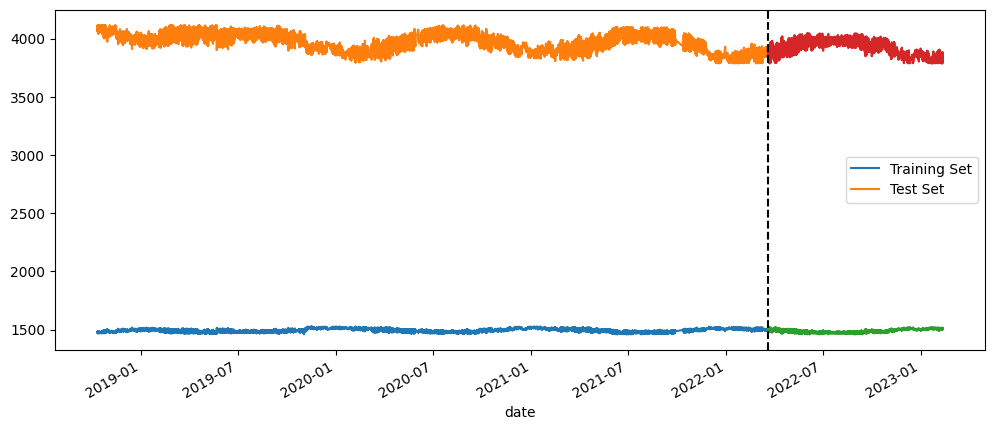

In [20]:
# Calculer l'indice de division
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index]
test = df.iloc[split_index:]

target_colonne = ["distx", "disty"]

fig, ax = plt.subplots(figsize=(12,5))
train[target_colonne].plot(ax=ax, label="Training Set")
test[target_colonne].plot(ax=ax, label="Test Set")
ax.axvline(pd.to_datetime(df.index[split_index]), color="black", ls="--")
ax.legend(["Training Set","Test Set"])
plt.show()

## Feature Correlation

In [21]:
df.columns

Index(['distx', 'disty', 'T_Amb_h', 'T_Fc_h', 'Vbat', 'minuteofhour',
       'minuteofday', 'minuteofmonth', 'minuteofyear', 'hourofday',
       'hourofmonth', 'hourofyear', 'dayofweek', 'dayofmonth', 'dayofyear',
       'weekofmonth', 'weekofyear', 'month', 'quarter', 'year', 'holidays'],
      dtype='object')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166051 entries, 2018-10-10 22:28:00+00:00 to 2023-02-10 19:40:00+00:00
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   distx          166051 non-null  float64
 1   disty          166051 non-null  float64
 2   T_Amb_h        166051 non-null  float64
 3   T_Fc_h         166051 non-null  float64
 4   Vbat           166051 non-null  float64
 5   minuteofhour   166051 non-null  int32  
 6   minuteofday    166051 non-null  int32  
 7   minuteofmonth  166051 non-null  int32  
 8   minuteofyear   166051 non-null  int32  
 9   hourofday      166051 non-null  int32  
 10  hourofmonth    166051 non-null  int32  
 11  hourofyear     166051 non-null  int32  
 12  dayofweek      166051 non-null  int32  
 13  dayofmonth     166051 non-null  int32  
 14  dayofyear      166051 non-null  int32  
 15  weekofmonth    166051 non-null  int32  
 16  weekofyear     166051 non-nu

In [23]:
# df.corr(method='spearman')
correlation_matrix = df.corr(method='pearson')

for target_column in target_colonne:
    # Trier les valeurs absolues des corrélations par rapport à la colonne cible par ordre décroissant
    sorted_correlations_abs = correlation_matrix[target_column].abs().sort_values(ascending=False)
    
    # Afficher les corrélations absolues par ordre décroissant avec la colonne cible
    print(f"\nAbsolute correlations with '{target_column}' (Pearson method):\n")
    print(sorted_correlations_abs)
    correlation_matrix


Absolute correlations with 'distx' (Pearson method):

distx            1.000000
T_Fc_h           0.874596
T_Amb_h          0.855282
disty            0.836283
Vbat             0.275542
hourofday        0.127699
minuteofday      0.127638
quarter          0.099586
month            0.093810
minuteofyear     0.093413
hourofyear       0.093413
dayofyear        0.093072
weekofyear       0.085161
minuteofmonth    0.031414
hourofmonth      0.031413
weekofmonth      0.029784
dayofmonth       0.027104
holidays         0.025940
year             0.022967
dayofweek        0.001883
minuteofhour     0.001401
Name: distx, dtype: float64

Absolute correlations with 'disty' (Pearson method):

disty            1.000000
distx            0.836283
T_Fc_h           0.712410
T_Amb_h          0.711904
year             0.516485
Vbat             0.274842
quarter          0.186426
month            0.179483
minuteofyear     0.179458
hourofyear       0.179458
dayofyear        0.179187
weekofyear       0.170479
hour

In [24]:
# df.corr(method='spearman')
correlation_matrix = df.corr(method='spearman')

for target_column in target_colonne:
    # Trier les valeurs absolues des corrélations par rapport à la colonne cible par ordre décroissant
    sorted_correlations_abs = correlation_matrix[target_column].abs().sort_values(ascending=False)
    
    # Afficher les corrélations absolues par ordre décroissant avec la colonne cible
    print(f"\nAbsolute correlations with '{target_column}' (spearman method):\n")
    print(sorted_correlations_abs)
    correlation_matrix


Absolute correlations with 'distx' (spearman method):

distx            1.000000
T_Fc_h           0.874262
T_Amb_h          0.854585
disty            0.842111
Vbat             0.345158
hourofday        0.119345
minuteofday      0.119216
quarter          0.106800
month            0.091863
hourofyear       0.091517
minuteofyear     0.091517
dayofyear        0.091132
weekofyear       0.082901
hourofmonth      0.029275
minuteofmonth    0.029274
weekofmonth      0.028065
holidays         0.027462
year             0.026346
dayofmonth       0.025422
minuteofhour     0.001206
dayofweek        0.000005
Name: distx, dtype: float64

Absolute correlations with 'disty' (spearman method):

disty            1.000000
distx            0.842111
T_Fc_h           0.710284
T_Amb_h          0.709259
year             0.504690
Vbat             0.367771
quarter          0.184046
month            0.169432
hourofyear       0.169321
minuteofyear     0.169321
dayofyear        0.169012
weekofyear       0.160004
ho

### Interprétation Globale des Résultats
SSR based F test : Ce test utilise la somme des résidus carrés (SSR) pour mesurer la proportion de la variance expliquée par les lags de la série temporelle candidate. La statistique F élevée et les p-values extrêmement faibles (0.0000) pour les lags de 1 et 2 indiquent que les lags de `feature` expliquent de manière significative la variation de `target`.
SSR based chi2 test : Ce test transforme la statistique F en une distribution chi-carré pour évaluer l'ajustement du modèle. Les p-values de 0.0000 pour les deux lags montrent que les lags de `feature` ont une influence significative sur `target`.
Likelihood ratio test : Ce test compare la vraisemblance des modèles avec et sans les lags de la série candidate. Les p-values de 0.0000 indiquent que les lags de `feature` ajoutent une valeur prédictive significative au modèle de `target`.
Parameter F test : Ce test est similaire au SSR based F test et vérifie les paramètres du modèle. Les p-values de 0.0000 confirment encore une fois la relation significative entre les lags de `feature` et `target`.

### Conclusion
Les résultats des tests de causalité de Granger montrent une relation de causalité significative entre `feature` et `target`. Les valeurs passées de `feature` sont utiles pour prédire les valeurs futures de `target`, comme indiqué par les p-values très faibles pour tous les tests et pour les lags de 1 et 2 périodes. Cela suggère que `feature` Granger-cause `target`, ce qui est essentiel pour la modélisation et la prévision des séries temporelles dans ce contexte. Plus p est faible (<0.05) plus la variable doit etre utilisee pour la prediction.

In [25]:
max_lag = 1

list_colonne = df.columns

for target_column in target_colonne:
    print(f"Granger Causality Test for '{target_column}':")
    for i in list_colonne:
        if i not in target_colonne:
            print(i)
            grangercausalitytests(train[[i, target_column]], maxlag=max_lag)
            print("---------------------------------------------------------------------------------")
    print("\n====================================================================================")

Granger Causality Test for 'distx':
T_Amb_h

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=819.3542, p=0.0000  , df_denom=132836, df_num=1
ssr based chi2 test:   chi2=819.3727, p=0.0000  , df=1
likelihood ratio test: chi2=816.8560, p=0.0000  , df=1
parameter F test:         F=819.3542, p=0.0000  , df_denom=132836, df_num=1
---------------------------------------------------------------------------------
T_Fc_h

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1183.4127, p=0.0000  , df_denom=132836, df_num=1
ssr based chi2 test:   chi2=1183.4394, p=0.0000  , df=1
likelihood ratio test: chi2=1178.1990, p=0.0000  , df=1
parameter F test:         F=1183.4127, p=0.0000  , df_denom=132836, df_num=1
---------------------------------------------------------------------------------
Vbat

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=605.3358, p=0.0000  , df_denom=132836, df_num=1
ssr based chi2 test:   chi2=605.3495, 

### Maintenant a base des deux resultats precedents, on peut choisir les varialbles explicatives avec lequelles on veux faire la regression.

## Predictions

## DistX

In [26]:
train.columns

Index(['distx', 'disty', 'T_Amb_h', 'T_Fc_h', 'Vbat', 'minuteofhour',
       'minuteofday', 'minuteofmonth', 'minuteofyear', 'hourofday',
       'hourofmonth', 'hourofyear', 'dayofweek', 'dayofmonth', 'dayofyear',
       'weekofmonth', 'weekofyear', 'month', 'quarter', 'year', 'holidays'],
      dtype='object')

In [27]:
# Création des variables explicatives et de la variable cible
feature = ['T_Amb_h', 'T_Fc_h', 'Vbat', 'minuteofhour',
       'minuteofday', 'minuteofmonth', 'minuteofyear', 'hourofday',
       'hourofmonth', 'hourofyear', 'dayofweek', 'dayofmonth', 'dayofyear',
       'weekofmonth', 'weekofyear', 'month', 'quarter', 'year', 'holidays']
target = 'distx'

In [28]:
x_train = train[feature]
y_train = train[target]
x_test = test[feature]
y_test = test[target]

### Recherche des meilleurs parametres

In [29]:
# Initialisation des paramètres de configuration globale
global_params = {
    'verbosity': 0,  # Default: 1 (0 = silent, 1 = warning, 2 = info, 3 = debug)
    'use_rmm': False,  # Default: False (use_rmm = True/False)
}

# Initialisation des paramètres généraux
general_params = {
    'booster': 'gbtree',  # Default: gbtree (Options: gbtree, gblinear, dart)
    'device': 'cpu',  # Default: cpu (Options: cpu, cuda, gpu)
    'verbosity': 0,  # Default: 1 (0 = silent, 1 = warning, 2 = info, 3 = debug)
    'validate_parameters': True,  # Default: False (validate_parameters = True/False)
    'nthread': -1,  # Default: Maximum number of threads available (-1 uses all available threads)
    'disable_default_eval_metric': False,  # Default: False (disable_default_eval_metric = True/False)
}

# Initialisation des paramètres pour le booster d'arbres
tree_params = {
    'eta': 0.4,  # Default: 0.3 (Learning rate) 0.4
    'gamma': df['distx'].std(),  # Default: 0 (Minimum loss reduction required to make a partition)
    'max_depth': len(feature),  # Default: 6 (Maximum depth of a tree)
    'min_child_weight': df['distx'].min(),  # Default: 1 (Minimum sum of instance weight needed in a child)
    'max_delta_step': df['distx'].std(),  # Default: 0 (Maximum delta step we allow each tree's weight estimate to be)
    'subsample': 0.7,  # Default: 1 (Subsample ratio of the training instances)
    'sampling_method': 'uniform',  # Default: uniform (Options: uniform, gradient_based)
    'colsample_bytree': 0.7,  # Default: 1 (Subsample ratio of columns when constructing each tree)
    'colsample_bylevel': 0.5,  # Default: 1 (Subsample ratio of columns for each level)
    'colsample_bynode': 0.3,  # Default: 1 (Subsample ratio of columns for each split)
    'lambda': 1,  # Default: 1 (L2 regularization term on weights)
    'alpha': 1,  # Default: 0 (L1 regularization term on weights)
    'tree_method': 'approx',  # Default: auto (Options: auto, exact, approx, hist, gpu_hist)
    'scale_pos_weight': 1,  # Default: 1 (Control the balance of positive and negative weights)
    'refresh_leaf': 1,  # Default: 1 (Options: 0, 1; 1 means refreshing the tree's leaf values)
    'process_type': 'default',  # Default: default (Options: default, update)
    'grow_policy': 'depthwise',  # Default: depthwise (Options: depthwise, lossguide)
    'max_leaves': 0,  # Default: 0 (Maximum number of leaves in the tree)
    'max_bin': 256,  # Default: 256 (Number of bins for histogram construction)
    'num_parallel_tree': 5,  # Default: 1 (Number of trees to grow per iteration)
}

# Initialisation des paramètres pour les caractéristiques catégorielles
categorical_params = {
    'max_cat_to_onehot': 32,  # Default: 4 (Threshold for deciding whether to use one-hot encoding based split)
    'max_cat_threshold': 32,  # Default: 64 (Maximum number of categories considered for each split)
}

# Initialisation des paramètres de la tâche d'apprentissage
task_params = {
    'objective': 'reg:squarederror',  # Default: reg:squarederror (Objective function; Options vary based on task)
    'eval_metric': 'rmse',  # Default: rmse (Evaluation metric; multiple options based on task)
    'base_score': df['distx'].median(),  # Default: 0.5 (Initial prediction score of all instances)
}

# Combinaison de tous les paramètres
best_params_xgb = {**global_params, **general_params, **tree_params, **categorical_params, **task_params}

### Creation du model

In [30]:
# Entraînement du modèle XGBoost avec les meilleurs paramètres
model_xgb = XGBRegressor(**best_params_xgb)

### Entrainement du model

In [31]:
# Enregistrer le temps de début
start_time = time.time()

model_xgb.fit(x_train, y_train)

# Enregistrer le temps de fin
end_time = time.time()

### Phase de prediction

In [32]:
y_pred_xgb = model_xgb.predict(x_test)

### Calcul et affichage de l'erreur

In [33]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# Affichage des résultats
print("MSE XGBoost:", mse_xgb)

# RSME XGBoost
rmse_xgb = np.sqrt(mse_xgb)
print("RSME XGBoost:", rmse_xgb)

#accuracy
accuracy = model_xgb.score(x_test, y_test)
print("Accuracy XGBoost:", accuracy)

# Calculer la durée d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

MSE XGBoost: 11.23405985957881
RSME XGBoost: 3.351724908100128
Accuracy XGBoost: 0.9365104286991826
Temps d'exécution : 4.531803369522095 secondes


### Visualisation des resultats

In [34]:
test["prediction_x"] = y_pred_xgb
test[[target,"prediction_x"]]

C:\Users\DM8196\AppData\Local\Temp\ipykernel_14172\2915797878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_x"] = y_pred_xgb


,distx,prediction_x
date,,
2022-03-20 01:28:00+00:00,1507.0,1504.164673
2022-03-20 01:40:00+00:00,1507.0,1502.038696
2022-03-20 01:52:00+00:00,1507.0,1501.997681
2022-03-20 02:04:00+00:00,1507.0,1501.824585
2022-03-20 02:16:00+00:00,1507.0,1501.537964
...,...,...
2023-02-10 18:52:00+00:00,1514.0,1512.282104
2023-02-10 19:04:00+00:00,1514.0,1514.132568
2023-02-10 19:16:00+00:00,1514.0,1515.007568


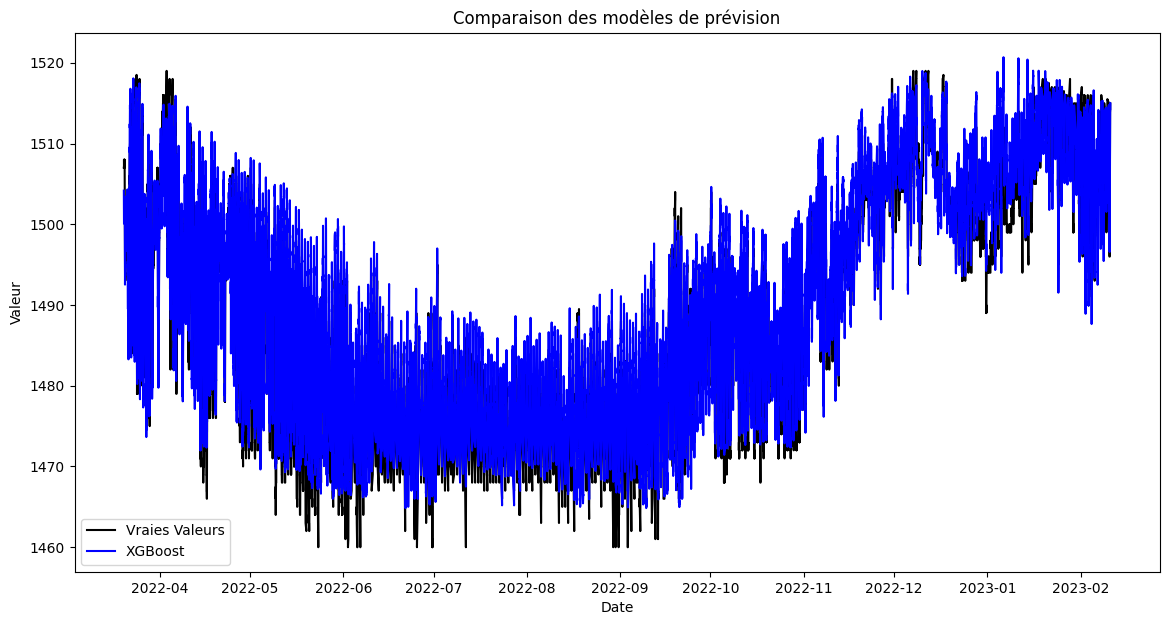

In [35]:
# Visualisation des résultats
plt.figure(figsize=(14, 7))
target_test = test['distx']
prediction = test['prediction_x']
plt.plot(df.index[-len(y_test):], target_test, label='Vraies Valeurs', color='black')
plt.plot(df.index[-len(y_test):], prediction, label='XGBoost', color='blue')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()

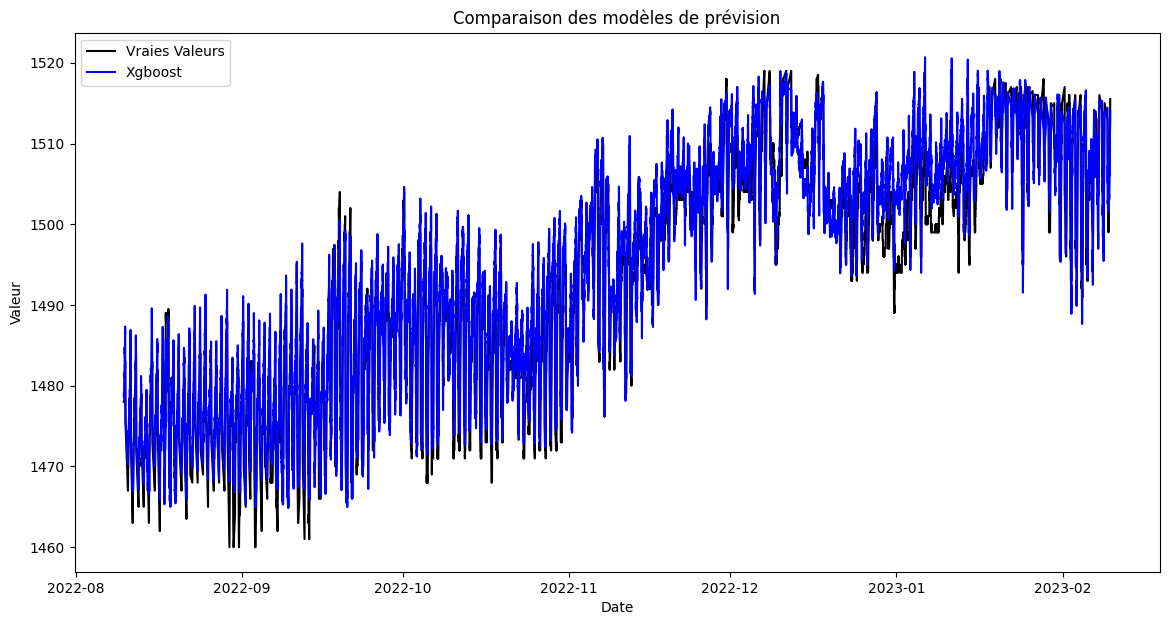

In [36]:
# Définir l'intervalle de dates
start_date = '2022-08-10'
end_date = '2023-02-10'

# Filtrer les données pour cet intervalle
mask = (test.index >= start_date) & (test.index <= end_date)
filtered_dates = test.index[mask]
filtered_y_test = target_test[mask]
filtered_y_pred_rf = prediction[mask]

# Visualisation des résultats pour l'intervalle de dates spécifié
plt.figure(figsize=(14, 7))
plt.plot(filtered_dates, filtered_y_test, label='Vraies Valeurs', color='black')
plt.plot(filtered_dates, filtered_y_pred_rf, label='Xgboost', color='blue')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()

## DistY

In [37]:
# Création des variables explicatives et de la variable cible
feature = ['T_Amb_h', 'T_Fc_h', 'Vbat','hourofday', 'hourofmonth']
target = 'disty'

x_train = train[feature]
y_train = train[target]
x_test = test[feature]
y_test = test[target]

# Initialisation des paramètres de configuration globale
global_params = {
    'verbosity': 0,  # Default: 1 (0 = silent, 1 = warning, 2 = info, 3 = debug)
    'use_rmm': False,  # Default: False (use_rmm = True/False)
}

# Initialisation des paramètres généraux
general_params = {
    'booster': 'gbtree',  # Default: gbtree (Options: gbtree, gblinear, dart)
    'device': 'cpu',  # Default: cpu (Options: cpu, cuda, gpu)
    'verbosity': 0,  # Default: 1 (0 = silent, 1 = warning, 2 = info, 3 = debug)
    'validate_parameters': True,  # Default: False (validate_parameters = True/False)
    'nthread': -1,  # Default: Maximum number of threads available (-1 uses all available threads)
    'disable_default_eval_metric': False,  # Default: False (disable_default_eval_metric = True/False)
}

# Initialisation des paramètres pour le booster d'arbres
tree_params = {
    'eta': 0.4,  # Default: 0.3 (Learning rate)
    'gamma': df['disty'].std(),  # Default: 0 (Minimum loss reduction required to make a partition)
    'max_depth': len(feature),  # Default: 6 (Maximum depth of a tree)
    'min_child_weight': df['disty'].min(),  # Default: 1 (Minimum sum of instance weight needed in a child)
    'max_delta_step': df['disty'].std(),  # Default: 0 (Maximum delta step we allow each tree's weight estimate to be)
    'subsample': 0.7,  # Default: 1 (Subsample ratio of the training instances)
    'sampling_method': 'uniform',  # Default: uniform (Options: uniform, gradient_based)
    'colsample_bytree': 0.7,  # Default: 1 (Subsample ratio of columns when constructing each tree)
    'colsample_bylevel': 0.5,  # Default: 1 (Subsample ratio of columns for each level)
    'colsample_bynode': 0.3,  # Default: 1 (Subsample ratio of columns for each split)
    'lambda': 1,  # Default: 1 (L2 regularization term on weights)
    'alpha': 0,  # Default: 0 (L1 regularization term on weights)
    'tree_method': 'approx',  # Default: auto (Options: auto, exact, approx, hist, gpu_hist)
    'scale_pos_weight': 1,  # Default: 1 (Control the balance of positive and negative weights)
    'refresh_leaf': 1,  # Default: 1 (Options: 0, 1; 1 means refreshing the tree's leaf values)
    'process_type': 'default',  # Default: default (Options: default, update)
    'grow_policy': 'depthwise',  # Default: depthwise (Options: depthwise, lossguide)
    'max_leaves': 0,  # Default: 0 (Maximum number of leaves in the tree)
    'max_bin': 256,  # Default: 256 (Number of bins for histogram construction)
    'num_parallel_tree': 5,  # Default: 1 (Number of trees to grow per iteration)
}

# Initialisation des paramètres pour les caractéristiques catégorielles
categorical_params = {
    'max_cat_to_onehot': 32,  # Default: 4 (Threshold for deciding whether to use one-hot encoding based split)
    'max_cat_threshold': 32,  # Default: 64 (Maximum number of categories considered for each split)
}

# Initialisation des paramètres de la tâche d'apprentissage
task_params = {
    'objective': 'reg:squarederror',  # Default: reg:squarederror (Objective function; Options vary based on task)
    'eval_metric': 'rmse',  # Default: rmse (Evaluation metric; multiple options based on task)
    'base_score': df['disty'].median()  # Default: 0.5 (Initial prediction score of all instances)
}

# Combinaison de tous les paramètres
best_params_xgb = {**global_params, **general_params, **tree_params, **categorical_params, **task_params}
    

# Entraînement du modèle XGBoost avec les meilleurs paramètres
model_xgb = XGBRegressor(**best_params_xgb)

# Enregistrer le temps de début
start_time = time.time()

model_xgb.fit(x_train, y_train)

# Enregistrer le temps de fin
end_time = time.time()

y_pred_xgb = model_xgb.predict(x_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# Affichage des résultats
print("MSE XGBoost:", mse_xgb)

# RSME XGBoost
rmse_xgb = np.sqrt(mse_xgb)
print("RSME XGBoost:", rmse_xgb)

#accuracy
accuracy = model_xgb.score(x_test, y_test)
print("Accuracy XGBoost:", accuracy)

# Calculer la durée d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

test["prediction_y"] = y_pred_xgb
test[[target,"prediction_y"]]

MSE XGBoost: 2800.470952170121
RSME XGBoost: 52.919476113904615
Accuracy XGBoost: 0.2164311108344772
Temps d'exécution : 2.2401046752929688 secondes


C:\Users\DM8196\AppData\Local\Temp\ipykernel_14172\1069885671.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_y"] = y_pred_xgb


,disty,prediction_y
date,,
2022-03-20 01:28:00+00:00,3842.0,3894.687988
2022-03-20 01:40:00+00:00,3842.0,3905.048096
2022-03-20 01:52:00+00:00,3843.0,3910.366699
2022-03-20 02:04:00+00:00,3843.0,3910.383789
2022-03-20 02:16:00+00:00,3843.0,3915.808594
...,...,...
2023-02-10 18:52:00+00:00,3795.0,3824.425537
2023-02-10 19:04:00+00:00,3794.0,3830.220215
2023-02-10 19:16:00+00:00,3792.0,3835.308105


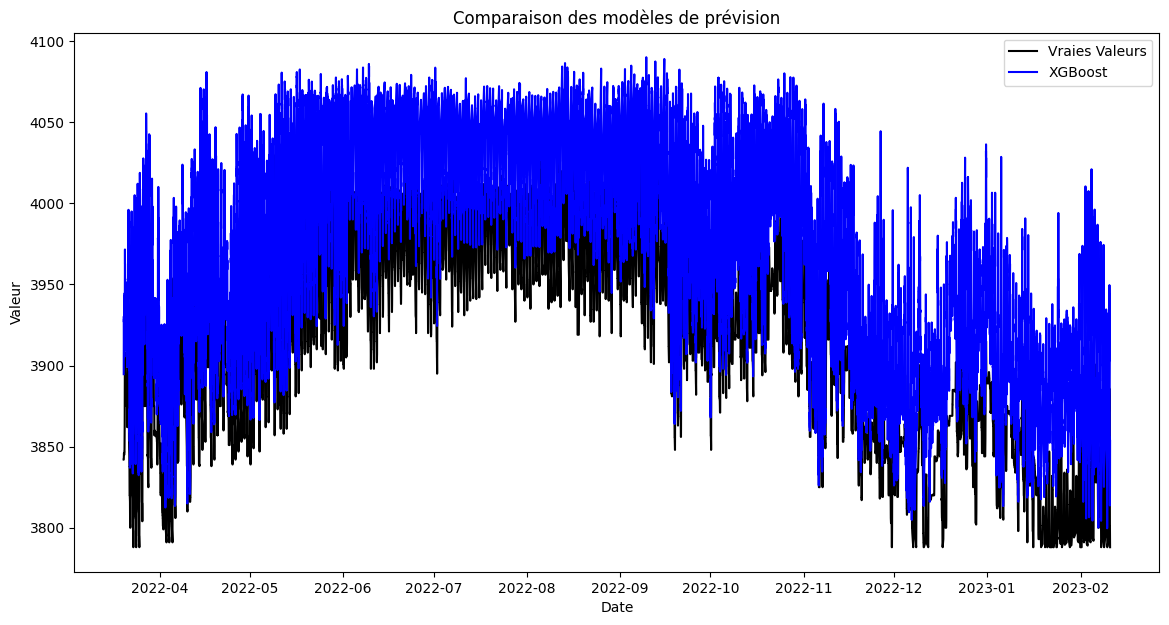

In [38]:
# Visualisation des résultats
plt.figure(figsize=(14, 7))
target_test = test['disty']
prediction = test['prediction_y']
plt.plot(df.index[-len(y_test):], target_test, label='Vraies Valeurs', color='black')
plt.plot(df.index[-len(y_test):], prediction, label='XGBoost', color='blue')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()

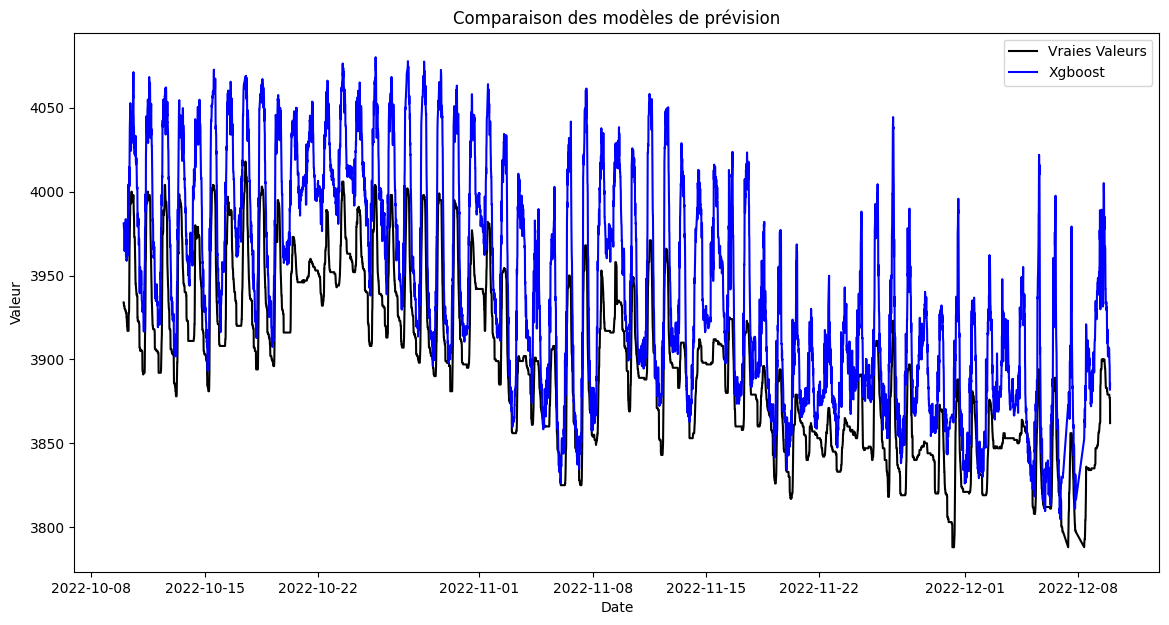

In [39]:
# Définir l'intervalle de dates
start_date = '2022-10-10'
end_date = '2022-12-10'

# Filtrer les données pour cet intervalle
mask = (test.index >= start_date) & (test.index <= end_date)
filtered_dates = test.index[mask]
filtered_y_test = target_test[mask]
filtered_y_pred_rf = prediction[mask]

# Visualisation des résultats pour l'intervalle de dates spécifié
plt.figure(figsize=(14, 7))
plt.plot(filtered_dates, filtered_y_test, label='Vraies Valeurs', color='black')
plt.plot(filtered_dates, filtered_y_pred_rf, label='Xgboost', color='blue')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()